
# Headers



In [1]:
%matplotlib inline
import cobra
import PyDSTool as dst
import pandas as pd
import matplotlib.pyplot as plt
import copy
import sys
import pdb


# Utility Functions



In [5]:
# Functions for initialization

def cleanupname(name):
    """
     The reaction names in the model files 
     don't have brackets or parentheses. I replaced
     those found in the mediaFluxes file.
     """
    name = name.replace('[', '_LPAREN_')
    name = name.replace(']', '_RPAREN_')
    name = name.replace('(', '_LPAREN_')
    name = name.replace(')', '_RPAREN_')
    return name

def defineDFBAModel(SpeciesDict , MediaDF):
    print("Defining Dynamical model... \n")
    ParDef = dict()
    VarDef = dict()
    ICS = dict()
    exchange_list = []
    mediaDerivedComponents = {}
    for i, row in MediaDF.iterrows():
        N = cleanupname(row.Reaction)
        mediaDerivedComponents[N] = row['Flux Value'] / (24.0*60.0) # Per minute

    for species in SpeciesDict.keys():
        SpeciesDict[species]['SpeciesModel'] = cobra.io.read_sbml_model(SpeciesDict[species]['File'])
        SpeciesDict[species]['OriginalLB'] = {r.id:r.lower_bound for r in SpeciesDict[species]['SpeciesModel'].exchanges}
        SpeciesDict[species]['solution'] = SpeciesDict[species]['SpeciesModel'].optimize()
        SpeciesDict[species]['Name'] = SpeciesDict[species]['SpeciesModel'].name.split(' ')[0]
        exchange_list += SpeciesDict[species]['SpeciesModel'].exchanges
        Name=SpeciesDict[species]['Name']
        ParDef['mu' + '_' + Name] = SpeciesDict[species]['solution'].objective_value/60
        VarDef[Name] =  'mu_' + Name + ' * ' + Name + '- ' +'Dilution * ' + Name ### Biomass
        ICS[Name] = SpeciesDict[species]['initAbundance']
    ParDef['Dilution'] = 0.002
    all_exchanges = set()

    for ex in exchange_list:
        all_exchanges.add(ex.id)
        #     all_exchanges = list(set(exchange_list))

    for rid in all_exchanges:
        VarDef[rid] =  '-Dilution * ' + rid
        ICS[rid] = 0.1

        if rid in mediaDerivedComponents.keys():
            ParDef[rid + '_influx'] = mediaDerivedComponents[rid]
            VarDef[rid] += ' + ' +  rid + '_influx'

        for species in SpeciesDict.keys():
            # print(SpeciesDict[species]['Name'])
            if 'h2o' in rid:
                print(species, rid)
            if rid in [species_r.id for species_r in SpeciesDict[species]['SpeciesModel'].exchanges]:
                Name = SpeciesDict[species]['Name']
                ParDef[rid + '_' + Name] = SpeciesDict[species]['solution'].fluxes[rid]/60.0
                VarDef[rid] += ' + ' +  rid + '_' + Name + ' * ' + Name

    ModelDef = dst.args(name='Community',
                    pars=ParDef,
                        varspecs=VarDef,
                        ics=ICS)
    ModelDS = dst.Vode_ODEsystem(ModelDef)
    print("Done!")
    return (SpeciesDict, ModelDef, ModelDS)

# Functions for model updates

def recomputeLowerBounds(SpeciesDict, PrevSteadyState, Kmax):
    for species in SpeciesDict.keys():
        for rid in [rxn.id for rxn in SpeciesDict[species]['SpeciesModel'].exchanges]:
            SpeciesDict[species]['SpeciesModel'].reactions.get_by_id(rid) \
                                                   .lower_bound = \
                                                                  SpeciesDict[species]['OriginalLB'][rid] \
                                                                  * PrevSteadyState[rid]/(Kmax+PrevSteadyState[rid])
    return SpeciesDict

def updateFluxParameters(SpeciesDict, ModelDS, PrevSteadyState):
    ParDef = {}
    ICS = {}
    for species in SpeciesDict:
        solution = SpeciesDict[species]['SpeciesModel'].optimize()
        Name = SpeciesDict[species]['Name']
        ParDef['mu_' + Name] = solution.objective_value/60.0
        ICS[Name] = PrevSteadyState[Name]
        exchanges = [r.id for r in SpeciesDict[species]['SpeciesModel'].exchanges]
        for rid in exchanges:
            ParDef[rid + '_' + Name] = solution.fluxes[rid]/60.0
            ICS[rid] = PrevSteadyState[rid]
    ModelDS.set(pars=ParDef, ics=ICS)
    return ModelDS

def update(SpeciesDict, ModelDS, PrevSteadyState, Kmax):
    UpdatedSpeciesDict = recomputeLowerBounds(SpeciesDict,
                                              PrevSteadyState, Kmax)

    UpdatedDynamicModel = updateFluxParameters(UpdatedSpeciesDict,
                                               ModelDS,
                                               PrevSteadyState)
    # P = simulateModel(updatedDynamicalModel)
    return(UpdatedSpeciesDict, UpdatedDynamicModel)

def get_ss(PointSet):
    SSPoints={}
    for k in PointSet.keys():
        SSPoints[k]=PointSet[k][-1]
    return(SSPoints)

def checkNegativeMetabolites(PointSet,StoreNegatives):
    IndexStop = len(PointSet['t'])

    for variable in PointSet.keys():
        if PointSet[variable][-1] < 0.0: # checking only final Tpoint, b/c monotonic
            varIndex = next((index for index,value in enumerate(list(PointSet[variable])) if value < 0.0), None)
            #varIndex= PointSet.index(filter(lambda x: x<0, PointSet)[0])
            if varIndex < IndexStop:
                # Update the index for the first negative crossing
                IndexStop = varIndex
               # print(IndexStop)

    if IndexStop < len(PointSet['t']) and IndexStop > 0:
        P_tilFirstNeg={}
        for variable in PointSet.keys():
            P_tilFirstNeg[variable]=P[variable][:IndexStop]
            if PointSet[variable][IndexStop] < 0:
                P_tilFirstNeg[variable][IndexStop-1] = 0.0
                print(P_tilFirstNeg[variable])
                StoreNegatives.add(variable)
                print(variable, 'is 0 at ', P['t'][IndexStop])
        P_tilFirstNeg['t'] = PointSet['t'][:IndexStop]
        PointSet = P_tilFirstNeg
    return(PointSet,StoreNegatives)


# Test:



In [10]:
# SpeciesDict = {'Sp1': {'File': './data/Bacteroides_sp_1_1_14.xml', 'initAbundance': 0.01},
#  'Sp10': {'File': './data/Desulfovibrio_piger_ATCC_29098.xml',
#   'initAbundance': 0.01},
#  'Sp2': {'File': './data/Ruminococcus_flavefaciens_FD_1.xml',
#   'initAbundance': 0.01},
#  'Sp3': {'File': './data/Lactobacillus_brevis_ATCC_367.xml',
#   'initAbundance': 0.01},
#  'Sp4': {'File': './data/Mycobacterium_avium_subsp_avium_ATCC_25291.xml',
#   'initAbundance': 0.01},
#  'Sp5': {'File': './data/Actinomyces_viscosus_C505.xml',
#   'initAbundance': 0.01},
#  'Sp6': {'File': './data/Exiguobacterium_aurantiacum_DSM_6208.xml',
#   'initAbundance': 0.01},
#  'Sp7': {'File': './data/Arcanobacterium_haemolyticum_DSM_20595.xml',
#   'initAbundance': 0.01},
#  'Sp8': {'File': './data/Streptococcus_intermedius_JTH08.xml',
#   'initAbundance': 0.01},
#  'Sp9': {'File': './data/Bifidobacterium_longum_infantis_ATCC_15697.xml',
#   'initAbundance': 0.01}}
SpeciesDict = {'Sp1': {'File':'./data/Bacteroides_sp_1_1_14.xml',
                      'initAbundance':2e-3},
                'Sp2': {'File':'./data/Actinomyces_viscosus_C505.xml',
                        'initAbundance':2e-3},
               'Sp3': {'File':'./data/Bifidobacterium_longum_infantis_ATCC_15697.xml',
                       'initAbundance':2e-3},
               #'Sp4': {'File':'./data/Desulfovibrio_piger_ATCC_29098.xml',
               #       'initAbundance':2e-3},
}
MediaDF = pd.read_csv('./data/VMH_HighFiber.tsv', sep='\t')

SpeciesDict, Definition, ModelDS = defineDFBAModel(SpeciesDict, MediaDF)
InitialValues = {k:[v] for (k,v) in Definition.ics.items()}

Defining Dynamical model... 

Sp3 EX_h2o__40__e__41__
Sp1 EX_h2o__40__e__41__
Sp2 EX_h2o__40__e__41__
Done!


In [11]:
AllPoints = []
StoreNegatives = set()
P = InitialValues
T0=0
TEND = 1000
TSPAN = 50
Kmax=0.01
i=0
MaxIter= 30
TERMINATE = False
while T0 < TEND and i < MaxIter:
#and not TERMINATE:
    i+=1
    print(T0)
   # print(P['EX_gln_L__40__e__41__'][-1])
    SpeciesDict, ModelDS = update(SpeciesDict, ModelDS, get_ss(P), Kmax)

    if T0+TSPAN > TEND:
        TSPAN = TEND - T0

    ModelDS.set(tdata=[T0, T0 + TSPAN])
    P = ModelDS.compute('test').sample() 

    # Initialize
    P, StoreNegatives = checkNegativeMetabolites(P,StoreNegatives) 
    T0 = P['t'][-1]
#     if len(P['t']) != 0:
#         T0 = P['t'][-1]
#     else:
#         TERMINATE = True

    AllPoints.append(P)

0
3342
3163
2144
1826
[0.1        0.09997362 0.09994721 ... 0.00026977 0.00016991 0.        ]
EX_sucr__40__e__41__ is 0 at  18.26365273054611
18.25365073014603
3963
1586
1280
393
371
[0.12347668 0.12318224 0.12288761 0.12259279 0.12229777 0.12200256
 0.12170716 0.12141157 0.12111578 0.1208198  0.12052363 0.12022726
 0.1199307  0.11963395 0.119337   0.11903986 0.11874252 0.11844499
 0.11814727 0.11784935 0.11755124 0.11725293 0.11695443 0.11665573
 0.11635683 0.11605775 0.11575846 0.11545898 0.11515931 0.11485944
 0.11455937 0.11425911 0.11395865 0.11365799 0.11335714 0.11305609
 0.11275485 0.11245341 0.11215177 0.11184993 0.1115479  0.11124567
 0.11094324 0.11064061 0.11033779 0.11003477 0.10973155 0.10942813
 0.10912451 0.1088207  0.10851669 0.10821247 0.10790806 0.10760345
 0.10729864 0.10699363 0.10668843 0.10638302 0.10607741 0.1057716
 0.1054656  0.10515939 0.10485298 0.10454637 0.10423957 0.10393256
 0.10362535 0.10331794 0.10301032 0.10270251 0.1023945  0.10208628
 0.10177786 0.

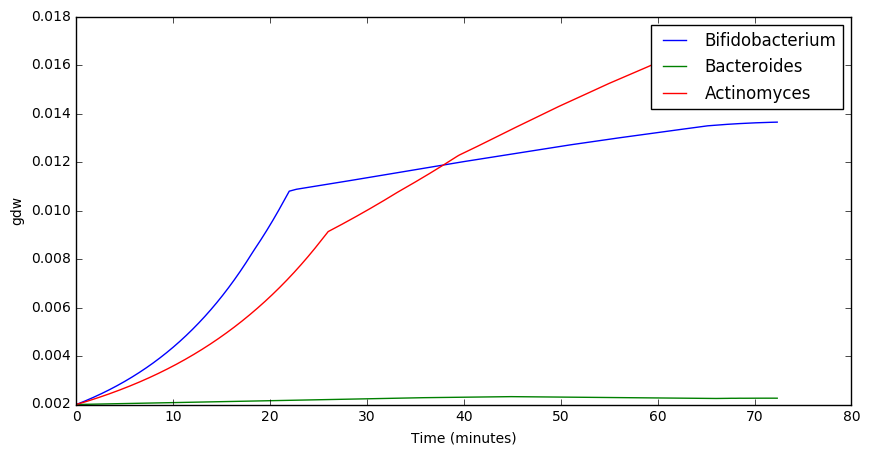

In [12]:
TimePoints={}
TimePoints['t'] =[]
plt.figure(figsize=(10,5))
for P in AllPoints:
    TimePoints['t'] += list(P['t'])
    
for sp in SpeciesDict.keys():
    TimePoints[SpeciesDict[sp]['Name']] = []
    for P in AllPoints:
        TimePoints[SpeciesDict[sp]['Name']]+=list(P[SpeciesDict[sp]['Name']])

for k in TimePoints.keys():
    if k!= 't':
        plt.plot(TimePoints['t'], TimePoints[k], label=k)
        plt.xlabel('Time (minutes)')
        plt.ylabel('gdw')
plt.xlabel('Time (minutes)')
plt.ylabel('gdw')
plt.legend()

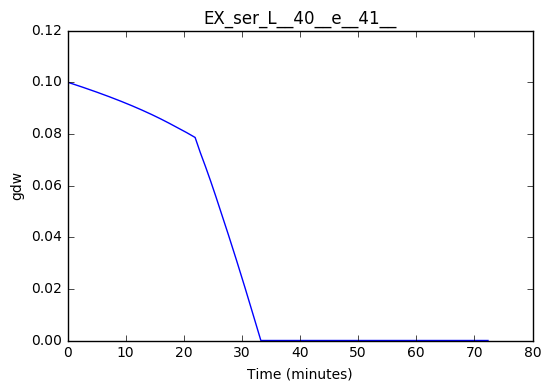

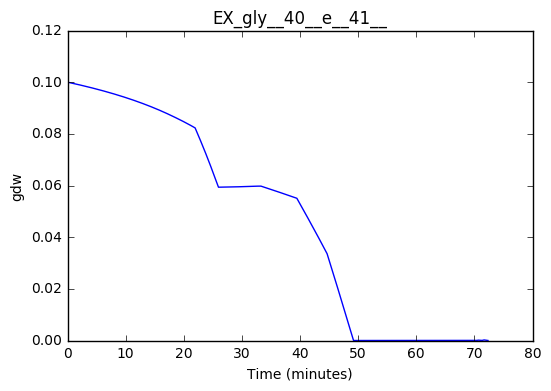

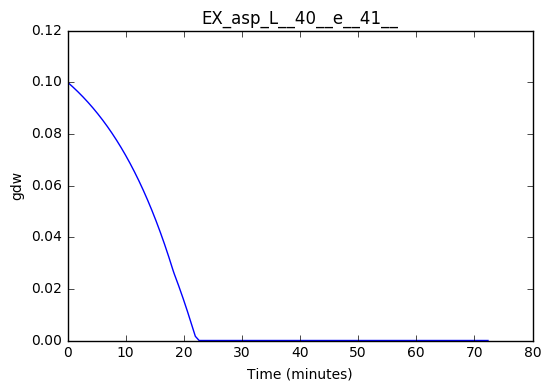

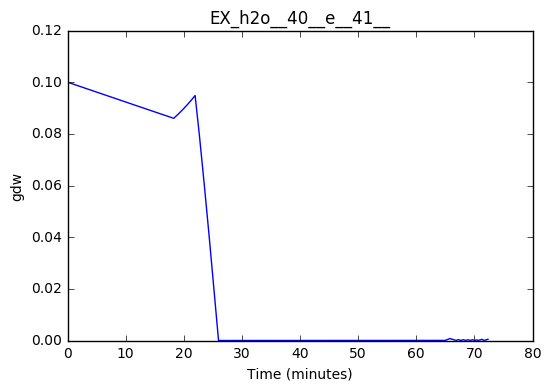

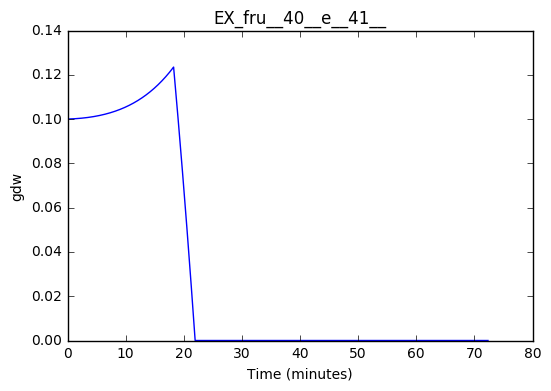

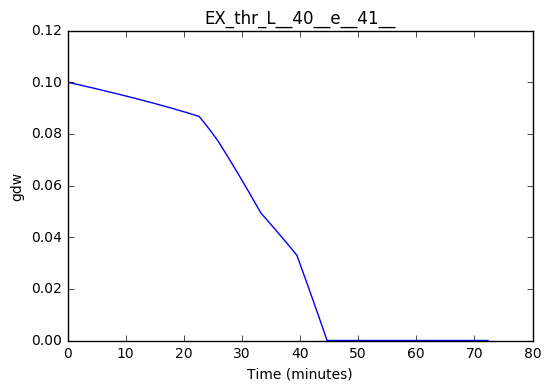

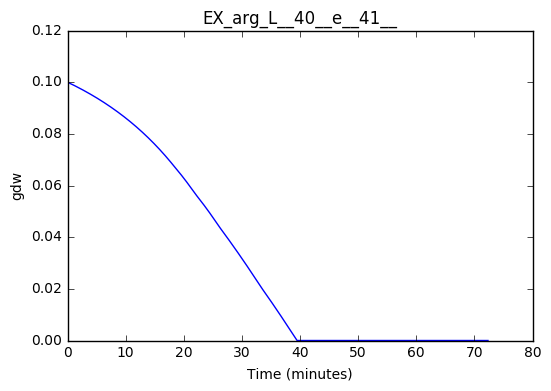

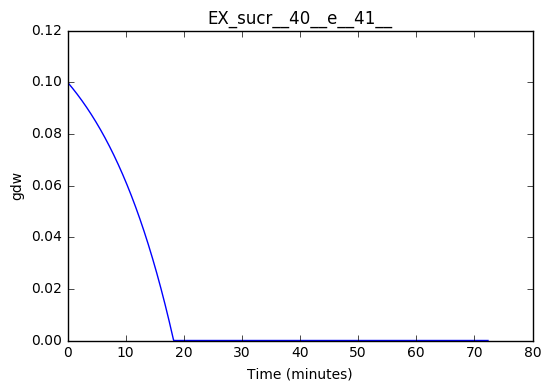

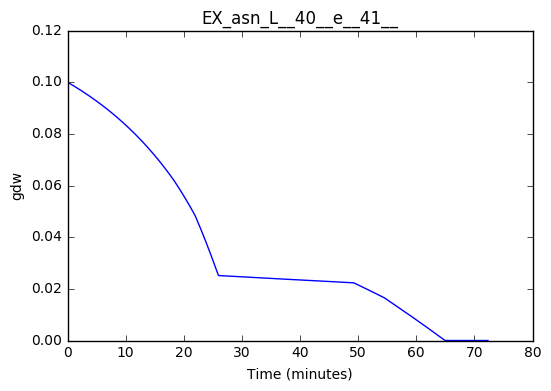

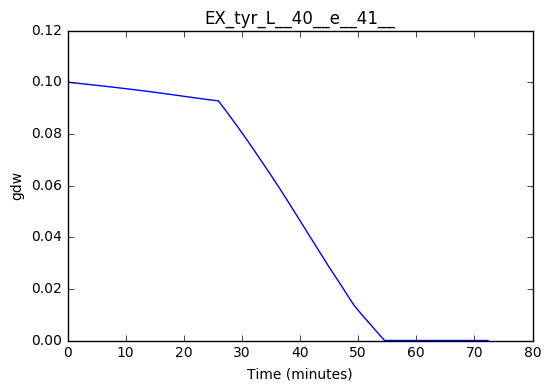

In [13]:
TimePoints={}
TimePoints['t'] =[]

for P in AllPoints:
    TimePoints['t'] += list(P['t'])
    
for variable in StoreNegatives:
    TimePoints[variable] = []
    for P in AllPoints:
        TimePoints[variable]+=list(P[variable])

for k in TimePoints.keys():
    if k != 't':
        plt.figure()
        plt.plot(TimePoints['t'], TimePoints[k])
    else:
        continue
    plt.title(k)    
    plt.xlabel('Time (minutes)')
    #plt.ylim([0,0.5])
    plt.ylabel('gdw')

In [ ]:

AllPoints[-1][]


In [ ]:
fname=['Bacteroides_sp_1_1_14', 
    'Ruminococcus_flavefaciens_FD_1',  
    'Lactobacillus_brevis_ATCC_367',  
    'Mycobacterium_avium_subsp_avium_ATCC_25291',  
    'Actinomyces_viscosus_C505',  
    'Exiguobacterium_aurantiacum_DSM_6208', 
    'Arcanobacterium_haemolyticum_DSM_20595',
    'Streptococcus_intermedius_JTH08',
    'Bifidobacterium_longum_infantis_ATCC_15697',
    'Desulfovibrio_piger_ATCC_29098']
count=1
d = {}
for f in fname:
    d['Sp' + str(count)] = {'File': './data/' + f +'.xml',
                            'initAbundance':1e-2}
    count +=1

In [ ]:
print(AllPoints[4]['EX_h2o__40__e__41__'])
A= AllPoints[4]['EX_h2o__40__e__41__']
B = list(A)
print(B)

In [ ]:
#varIndex= B.index(next(filter(lambda x: x<0, B)))
for i in range(0,len(B)):
    if B[i] < 0:
        print(i)
        print(B[i])
        break
varIndex = next((index for index,value in enumerate(list(B)) if value < 0.0), None)
print(varIndex)